##  Practice

## **Market Analysis Script Explanation**

This script is designed to analyze various financial datasets, including size, value, and momentum portfolios, and evaluate market factors using the Fama-French framework and CAPM (Capital Asset Pricing Model). Here's what the script does:

1. Setup and Imports

Libraries Used:
pandas, numpy: For data manipulation and calculations.
yfinance, pandas_datareader: For retrieving financial data.
seaborn, matplotlib: For visualization.
statsmodels: For regression analysis, including CAPM regressions.
requests_cache: To cache API calls and improve data retrieval speed.
ThreadPoolExecutor: For potential parallel processing.
Configurations:
Inline plotting with %matplotlib inline.
Retain precision formatting for numerical outputs.
2. Functionality Overview

A. Data Retrieval
Uses pandas_datareader to fetch Fama-French Factors and portfolio datasets.
Retrieves daily and monthly factors, size, value, and momentum portfolio data.
B. Statistical Measures
Defines utility functions:

mean: Calculates annualized mean return.
beta: Calculates CAPM beta (sensitivity to market movements).
date_range: Provides a human-readable date range for datasets.
C. Portfolio Analyses
Each portfolio type is analyzed using the Fama-French framework:

1. Size Portfolios

Data: Size portfolios (Portfolios_Formed_on_ME).
Analysis: Fits CAPM regressions for decile portfolios (e.g., Lo 10 to Hi 10).
Output:
Coefficient estimates (alphas and betas).
Bar plots of CAPM alpha values for size portfolios.
2. Value Portfolios

Data: Value portfolios (Portfolios_Formed_on_BE-ME).
Analysis: Similar to size portfolios but focuses on book-to-market deciles.
Output: Coefficients and visualizations of CAPM alpha values for value portfolios.
3. Momentum Portfolios

Data: Momentum portfolios (10_Portfolios_Prior_12_2).
Analysis: Fits CAPM regressions for momentum portfolios (Lo PRIOR to Hi PRIOR).
Output: Coefficient estimates and alpha plots for momentum portfolios.
D. ETF Analysis
Data: Daily returns of ETFs like SPY, GLD, and others via yfinance.
Analysis:
Computes annualized means and betas.
Plots the Security Market Line (SML) showing the relationship between beta and returns.
E. DJIA Analysis
Data: Daily returns for Dow Jones Industrial Average (DJIA) constituents.
Analysis:
Computes annualized means and betas for DJIA stocks.
Plots SML for DJIA stocks.
F. Beta Portfolios Analysis
Data: Beta portfolios (Portfolios_Formed_on_BETA).
Analysis:
Relates portfolio beta to returns.
Fits regressions to visualize the relationship using the SML.
G. Leveraged ETF Analysis
Data: Leveraged ETFs (e.g., SPY, UPRO, SPXU).
Analysis:
Calculates and compares CAPM beta values for leveraged ETFs.
Bar chart to illustrate beta differences.
H. Berkshire Hathaway Analysis
Data: Daily returns of Berkshire Hathaway (BRK-A) from yfinance.
Analysis:
Conducts rolling CAPM regression using three-factor Fama-French models.
Plots rolling regression coefficients over time.
3. Outputs

Regression Results:
Coefficients (alphas and betas) for size, value, and momentum portfolios.
Rolling coefficients for Berkshire Hathaway.
Visualizations:
Bar plots of CAPM alphas.
SML plots for ETFs, DJIA stocks, and beta portfolios.
Rolling regression trends.
Analysis Results:
ETF stats (annualized mean returns and betas).
DJIA stats.
Coefficients for portfolios (size, value, momentum).
Rolling coefficients for Berkshire Hathaway.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.formula.api as smf
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import warnings
import requests_cache
from concurrent.futures import ThreadPoolExecutor
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format
session = requests_cache.CachedSession()

In [2]:
def analyze_size_portfolios(ff_factors, session):
    """Analyze size portfolios with Fama-French data"""
    try:
        # Get size portfolio data
        size_data = pdr.DataReader(
            name='Portfolios_Formed_on_ME',
            data_source='famafrench',
            start='1900',
            session=session
        )
        
        ports = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']
        # Use equal-weighted returns (size_data[1]) as specified in the reference
        joined = size_data[1][ports].join(ff_factors)
        
        # Fit models through 1979 as in reference
        models = [smf.ols(f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=joined.loc[:'1979']) for p in ports]
        fits = [m.fit() for m in models]
        
        coefs = (
            pd.concat(
                objs=[f.params for f in fits],
                axis=1,
                keys=ports
            )
            .rename_axis(index='Coefficient', columns='Size Portfolio')
            .transpose()
        )
        
        ses = [f.bse[0] for f in fits]
        
        # Plotting
        plt.figure(figsize=(10, 6))
        coefs['Intercept'].plot(kind='bar', yerr=ses)
        plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
        plt.xticks(rotation=0)
        plt.title(
            r'Size Portfolio CAPM $\alpha$s for Monthly Returns' +
            '\nfrom July 1926 through December 1979'
        )
        plt.tight_layout()
        plt.show()
        
        return coefs
        
    except Exception as e:
        print(f"Error in size portfolio analysis: {e}")
        return pd.DataFrame()

def analyze_value_portfolios(ff_factors, session):
    """Analyze value (BE/ME) portfolios with Fama-French data"""
    try:
        # Get value portfolio data
        value_data = pdr.DataReader(
            name='Portfolios_Formed_on_BE-ME',
            data_source='famafrench',
            start='1900',
            session=session
        )
        
        ports = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']
        joined = value_data[1][ports].join(ff_factors)
        
        models = [smf.ols(f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=joined) for p in ports]
        fits = [m.fit() for m in models]
        
        coefs = (
            pd.concat(
                objs=[f.params for f in fits],
                axis=1,
                keys=ports
            )
            .rename_axis(index='Coefficient', columns='Equal-Weighted Value Portfolio')
            .transpose()
        )
        
        ses = [f.bse[0] for f in fits]
        
        # Plotting
        plt.figure(figsize=(10, 6))
        coefs['Intercept'].plot(kind='bar', yerr=ses)
        plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
        plt.xticks(rotation=45)
        plt.title(
            r'Value Portfolio CAPM $\alpha$s for Monthly Returns' +
            '\nfrom July 1926 through January 1979'
        )
        plt.tight_layout()
        plt.show()
        
        return coefs
        
    except Exception as e:
        print(f"Error in value portfolio analysis: {e}")
        return pd.DataFrame()

def analyze_momentum_portfolios(ff_factors, session):
    """Analyze momentum portfolios with Fama-French data"""
    try:
        # Get momentum portfolio data
        mom_data = pdr.DataReader(
            name='10_Portfolios_Prior_12_2',
            data_source='famafrench',
            start='1900',
            session=session
        )
        
        ports = ['Lo PRIOR', 'PRIOR 2', 'PRIOR 3', 'PRIOR 4', 'PRIOR 5', 
                'PRIOR 6', 'PRIOR 7', 'PRIOR 8', 'PRIOR 9', 'Hi PRIOR']
        joined = mom_data[1][ports].join(ff_factors)
        
        models = [smf.ols(f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=joined) for p in ports]
        fits = [m.fit() for m in models]
        
        coefs = (
            pd.concat(
                objs=[f.params for f in fits],
                axis=1,
                keys=ports
            )
            .rename_axis(index='Coefficient', columns='Equal-Weighted Momentum Portfolio')
            .transpose()
        )
        
        ses = [f.bse[0] for f in fits]
        
        # Plotting
        plt.figure(figsize=(10, 6))
        coefs['Intercept'].plot(kind='bar', yerr=ses)
        plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
        plt.xticks(rotation=45)
        plt.title(
            r'Momentum Portfolio CAPM $\alpha$s for Monthly Returns' +
            '\nfrom July 1926 through January 1979'
        )
        plt.tight_layout()
        plt.show()
        
        return coefs
        
    except Exception as e:
        print(f"Error in momentum portfolio analysis: {e}")
        return pd.DataFrame()
    
def perform_market_analysis(start_date=None, window_size=756):
    """
    Performs comprehensive market analysis including SML plots, factor analysis, and portfolio studies.
    
    Parameters:
    -----------
    start_date : str, optional
        Start date for analysis in 'YYYY-MM-DD' format. If None, uses last 'window_size' days
    window_size : int, default 756
        Number of trading days to analyze (default is ~3 years)
    
    Returns:
    --------
    dict
        Dictionary containing analysis results including ETF stats, DJIA stats, beta portfolios,
        leveraged betas, rolling coefficients, and various portfolio coefficients
    """
    # Setup
    pd.options.display.float_format = '{:.4f}'.format
    results = {}
    try:
        ff_monthly = pdr.DataReader(
            name='F-F_Research_Data_Factors',
            data_source='famafrench',
            start='1900',
            session=session
        )[0]
        
        # Get daily Fama-French factors for other analyses
        ff_factors = (pdr.DataReader(
            name='F-F_Research_Data_Factors_daily',
            data_source='famafrench',
            start='1900',
            session=session
        )[0].div(100))
    except Exception as e:
        print(f"Error downloading Fama-French factors: {e}")
        return None
    
    def mean(ri, ann=252, mul=100):
        return mul * ann * ri.mean()
    
    def beta(ri, rf=None, rm_rf=None):
        if rf is None or rm_rf is None:
            rf = ff_factors['RF']
            rm_rf = ff_factors['Mkt-RF']
        ri_rf = ri.sub(rf).dropna()
        return ri_rf.cov(rm_rf) / rm_rf.loc[ri_rf.index].var()
    
    def date_range(x):
        return f'{x.index[0]:%b %d, %Y} to {x.index[-1]:%b %d, %Y}'
    
    def plot_sml(data, title, save=True):
        if data.empty:
            print(f"Warning: No data available for {title}")
            return
            
        plt.figure(figsize=(10, 6))
        sns.regplot(x='beta', y='mean', data=data)
        for t, (x, y) in data[['beta', 'mean']].iterrows():
            plt.annotate(text=t, xy=(x, y))
        plt.ylabel('Annualized Mean of Daily Returns (%)')
        plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
        plt.title(title)
        if save:
            plt.savefig(f"{title.split('(')[0].strip().lower().replace(' ', '_')}.png")
        plt.show()
    
    # 1. Download Fama-French Factors
    try:
        ff_factors = (pdr.DataReader(
            name='F-F_Research_Data_Factors_daily',
            data_source='famafrench',
            start='1900',
            session=session
        )[0].div(100))
    except Exception as e:
        print(f"Error downloading Fama-French factors: {e}")
        return None
    
    # 2. ETF Analysis
    try:
        etf_tickers = 'SPY BIL GLD JNK MDY SLY SPBO SPMB SPTL'
        etf_data = (yf.download(tickers=etf_tickers, progress=False)
                   .assign(Date=lambda x: x.index.tz_localize(None))
                   .set_index('Date')['Adj Close']
                   .pct_change()
                   .dropna()
                   .iloc[-window_size:])
        
        if not etf_data.empty:
            etf_stats = etf_data.agg([mean, beta]).rename_axis(index='Statistic').transpose()
            plot_sml(etf_stats, 'Security Market Line (SML) for ETFs\n' + etf_data.pipe(date_range))
            results['etf_stats'] = etf_stats
    except Exception as e:
        print(f"Error in ETF analysis: {e}")
        results['etf_stats'] = pd.DataFrame()
    
    # 3. DJIA Analysis
    try:
        wiki = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
        tickers = wiki[2]['Symbol'].str.strip().tolist()
        
        djia_data = (
            yf.download(
                tickers=tickers,
                progress=False
            )
            .assign(Date=lambda x: x.index.tz_localize(None))
            .set_index('Date')
            .rename_axis(columns=['Variable', 'Ticker'])
            ['Adj Close']
            .pct_change()
            .dropna()
        )
        
        if not djia_data.empty:
            djia_stats = djia_data.agg([mean, beta]).rename_axis(index='Statistic').transpose()
            plot_sml(djia_stats, 'Security Market Line (SML) for DJIA Stocks\n' + djia_data.pipe(date_range))
            results['djia_stats'] = djia_stats
    except Exception as e:
        print(f"Error in DJIA analysis: {e}")
        results['djia_stats'] = pd.DataFrame()
    
    # 4. Beta Portfolios Analysis
    try:
        beta_portfolios = pdr.DataReader(
            name='Portfolios_Formed_on_BETA',
            data_source='famafrench',
            start='1900',
            session=session
        )
        
        ports = ['Lo 20', 'Qnt 2', 'Qnt 3', 'Qnt 4', 'Hi 20']
        beta_data = pd.concat(
            [
                beta_portfolios[6][ports].shift(),
                beta_portfolios[2][ports]
            ],
            axis=1,
            keys=['Beta', 'Return'],
            names=['Statistic', 'β Portfolio']
        ).stack()
        
        results['beta_portfolios'] = beta_data
        
        plt.figure(figsize=(10, 6))
        sns.regplot(x='Beta', y='Return', data=beta_data)
        plt.ylabel('Mean Annual Return (%)')
        plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
        plt.title(f'Security Market Line (SML) for β Portfolios\n' +
                 f'Annual Returns from {beta_data.index.get_level_values(0).year[0]} to {beta_data.index.get_level_values(0).year[-1]}')
        plt.savefig('beta_portfolios_sml.png')
        plt.show()
    except Exception as e:
        print(f"Error in beta portfolios analysis: {e}")
        results['beta_portfolios'] = pd.DataFrame()
    
    # 5. Leveraged ETF Analysis
    try:
        leveraged_etfs = (yf.download(tickers='SPY UPRO SPXU', progress=False)
                         .assign(Date=lambda x: x.index.tz_localize(None))
                         .set_index('Date')['Adj Close']
                         .pct_change()
                         .dropna())
        
        leveraged_betas = leveraged_etfs.apply(beta)
        results['leveraged_betas'] = leveraged_betas
        
        plt.figure(figsize=(10, 6))
        leveraged_betas.plot(kind='bar')
        plt.xticks(rotation=0)
        plt.ylabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
        plt.title(f'CAPM βs\nfrom Daily Returns from {leveraged_etfs.pipe(date_range)}')
        plt.savefig('leveraged_etfs_betas.png')
        plt.show()
    except Exception as e:
        print(f"Error in leveraged ETF analysis: {e}")
        results['leveraged_betas'] = pd.DataFrame()
    
    # 6. Berkshire Hathaway Analysis
    try:
        brk = (yf.download(tickers='BRK-A', progress=False)
               .assign(Date=lambda x: x.index.tz_localize(None))
               .set_index('Date')
               .assign(R=lambda x: x['Adj Close'].pct_change().mul(100))
               .dropna()
               .join(ff_factors, how='inner'))
        
        rolling_coefs = (RollingOLS.from_formula(
            formula='I(R-RF) ~ Q("Mkt-RF") + SMB + HML',
            data=brk,
            window=3*252
        ).fit()
         .params
         .rename_axis(columns='Coefficient')
         .rename(columns={'Q("Mkt-RF")': 'Mkt-RF'}))
        
        results['rolling_coefficients'] = rolling_coefs
        
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
        rolling_coefs['Intercept'].plot(ax=ax[0], legend=True)
        rolling_coefs.drop('Intercept', axis=1).plot(ax=ax[1])
        plt.suptitle('Rolling Three-Factor Regressions\nThree-Year Windows with Daily Returns in Percent')
        plt.savefig('berkshire_rolling_factors.png')
        plt.show()
    except Exception as e:
        print(f"Error in Berkshire Hathaway analysis: {e}")
        results['rolling_coefficients'] = pd.DataFrame()
    
    # 7. Portfolio Analysis Function
    def analyze_portfolios(data_name, ports, portfolio_type):
        try:
            data = pdr.DataReader(
                name=data_name,
                data_source='famafrench',
                start='1900',
                session=session
            )
            
            if len(data) < 2 or data[1].empty:
                print(f"No data available for {data_name}")
                return pd.DataFrame()
            
            joined_data = data[1][ports].join(ff_factors)
            if joined_data.empty:
                print(f"No joined data available for {data_name}")
                return pd.DataFrame()
            
            models = []
            for p in ports:
                formula = f'I(Q("{p}") - RF) ~ Q("Mkt-RF")'
                try:
                    model = smf.ols(formula, data=joined_data)
                    fit = model.fit()
                    models.append(fit)
                except Exception as e:
                    print(f"Error fitting model for portfolio {p}: {e}")
                    return pd.DataFrame()
            
            if not models:
                return pd.DataFrame()
            
            coefs = pd.concat(
                objs=[f.params for f in models],
                axis=1,
                keys=ports
            ).rename_axis(index='Coefficient', columns=f'{portfolio_type} Portfolio').transpose()
            
            ses = [f.bse[0] for f in models]
            
            plt.figure(figsize=(10, 6))
            coefs['Intercept'].plot(kind='bar', yerr=ses)
            plt.ylabel(r'Monthly $\alpha$ (%) from CAPM')
            plt.xticks(rotation=45)
            plt.title(f'{portfolio_type} Portfolio CAPM $\\alpha$s for Monthly Returns')
            plt.tight_layout()
            plt.show()
            
            return coefs
            
        except Exception as e:
            print(f"Error in {portfolio_type} portfolio analysis: {e}")
            return pd.DataFrame()
    
    # Analyze different portfolio types
    size_ports = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']
    value_ports = size_ports.copy()
    momentum_ports = ['Lo PRIOR', 'PRIOR 2', 'PRIOR 3', 'PRIOR 4', 'PRIOR 5', 
                     'PRIOR 6', 'PRIOR 7', 'PRIOR 8', 'PRIOR 9', 'Hi PRIOR']
    
    results['size_coefs'] = analyze_size_portfolios(ff_monthly, session)
    results['value_coefs'] = analyze_value_portfolios(ff_monthly, session)
    results['momentum_coefs'] = analyze_momentum_portfolios(ff_monthly, session)
    
    return results

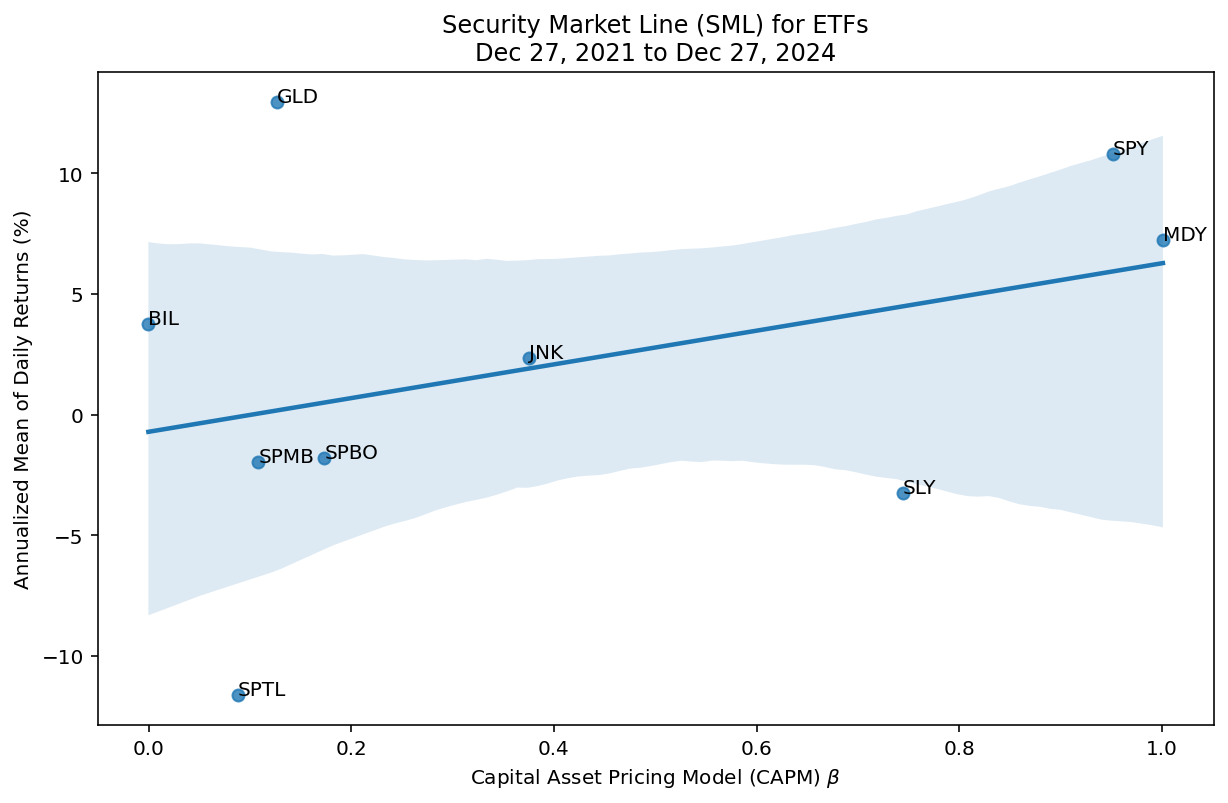

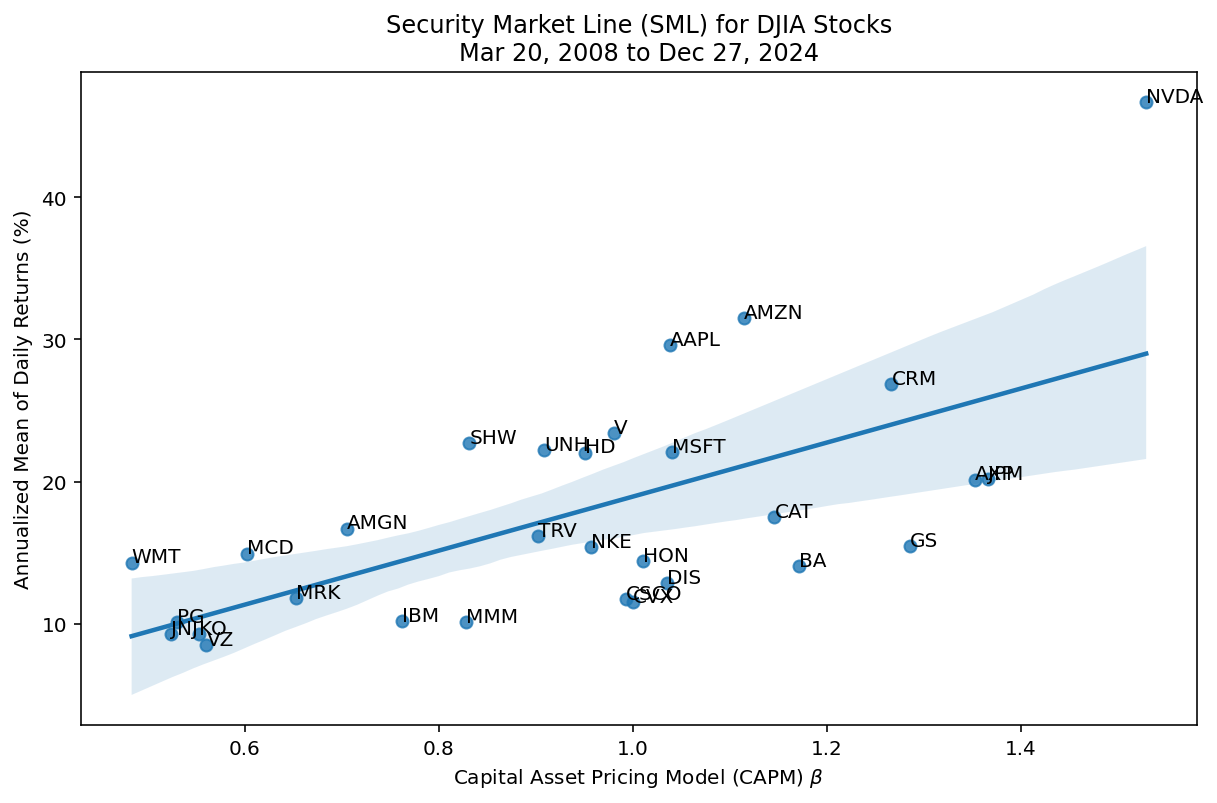

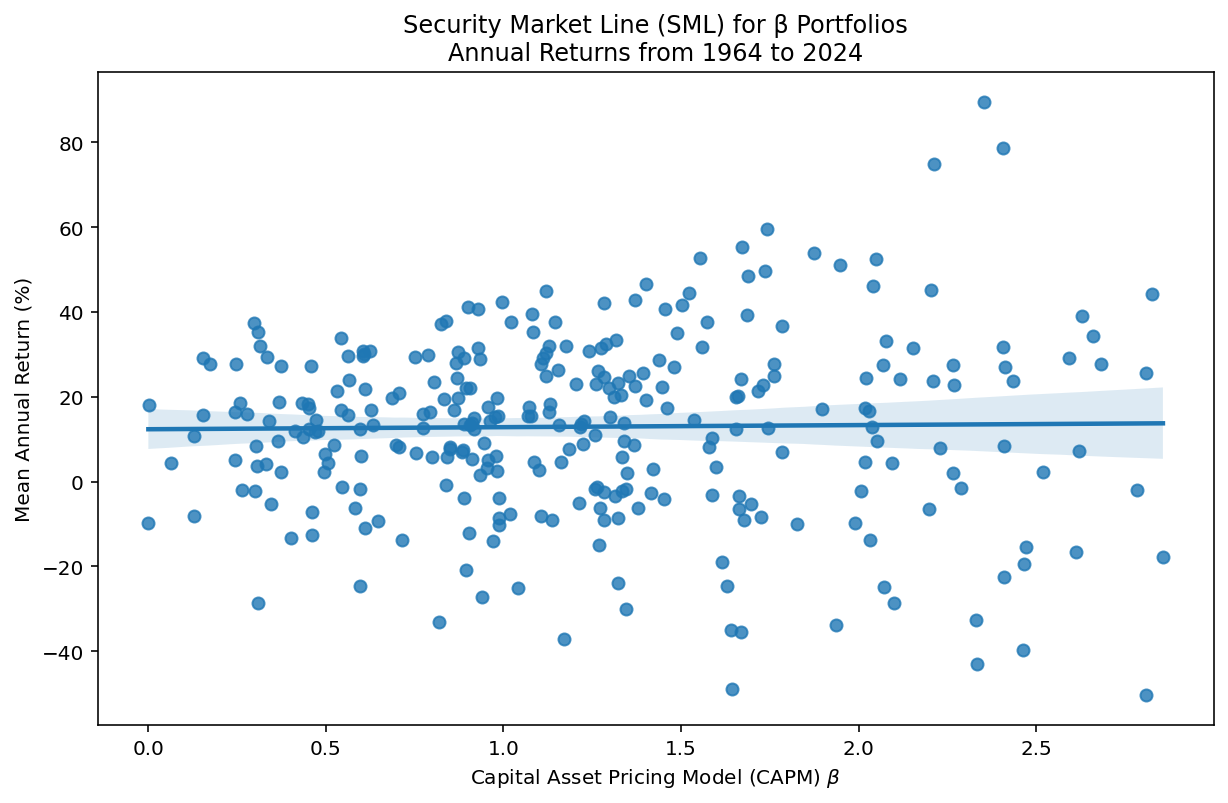

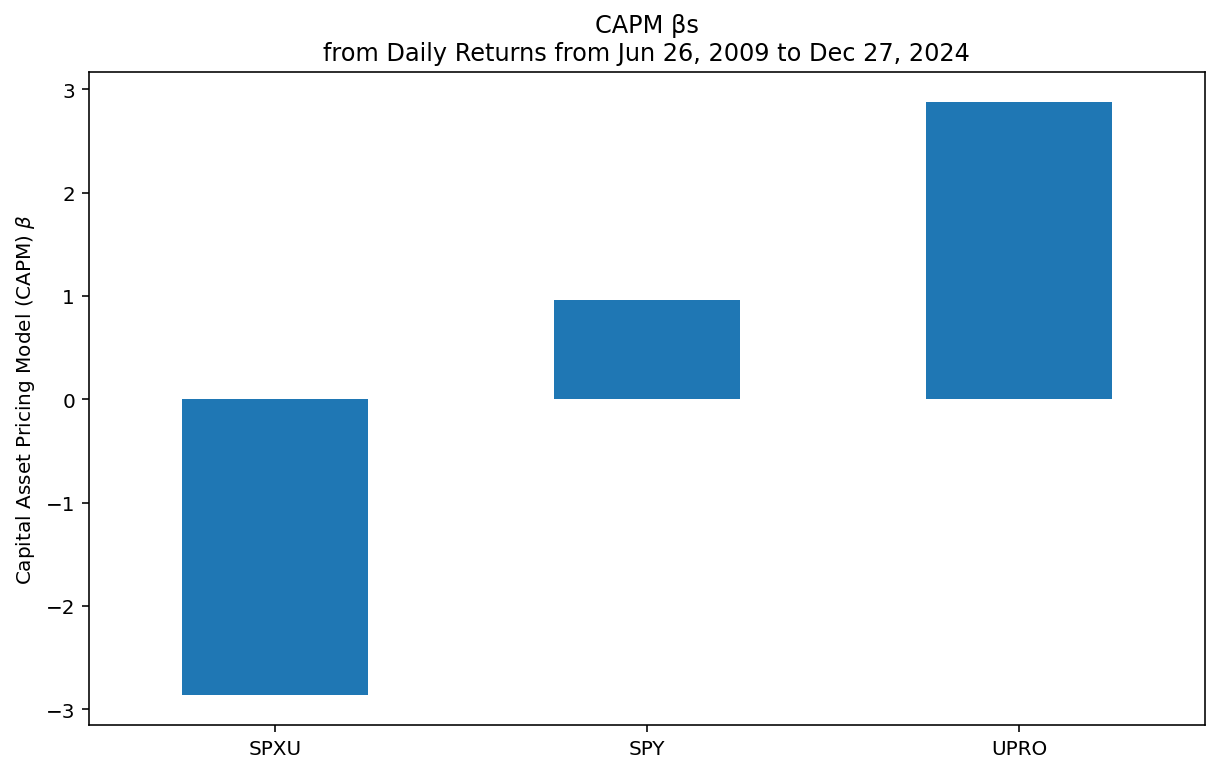

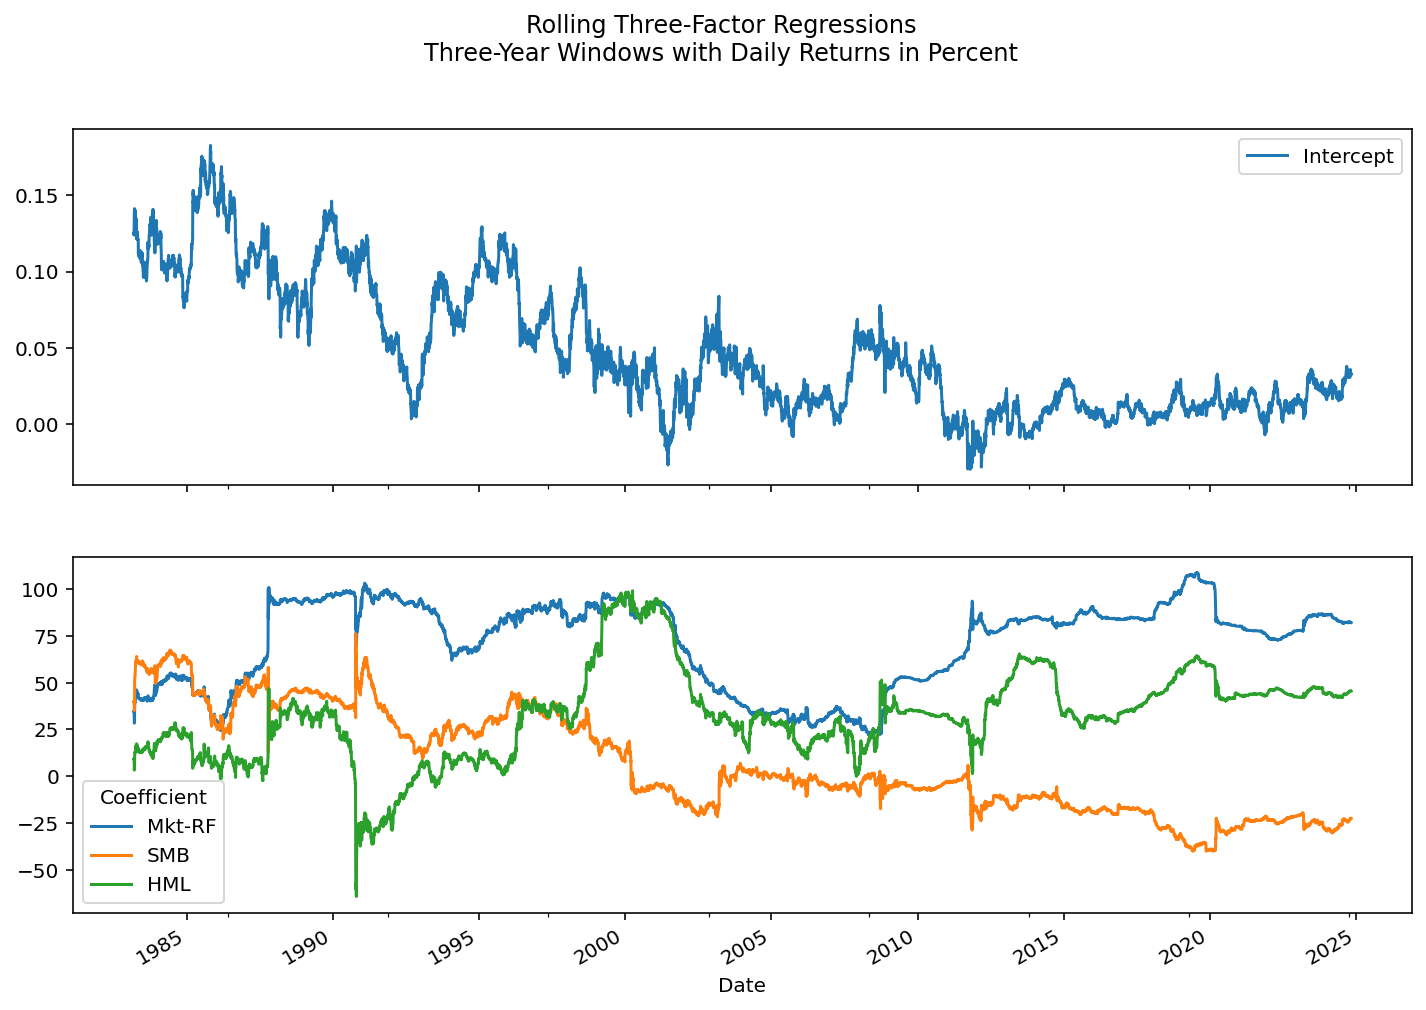

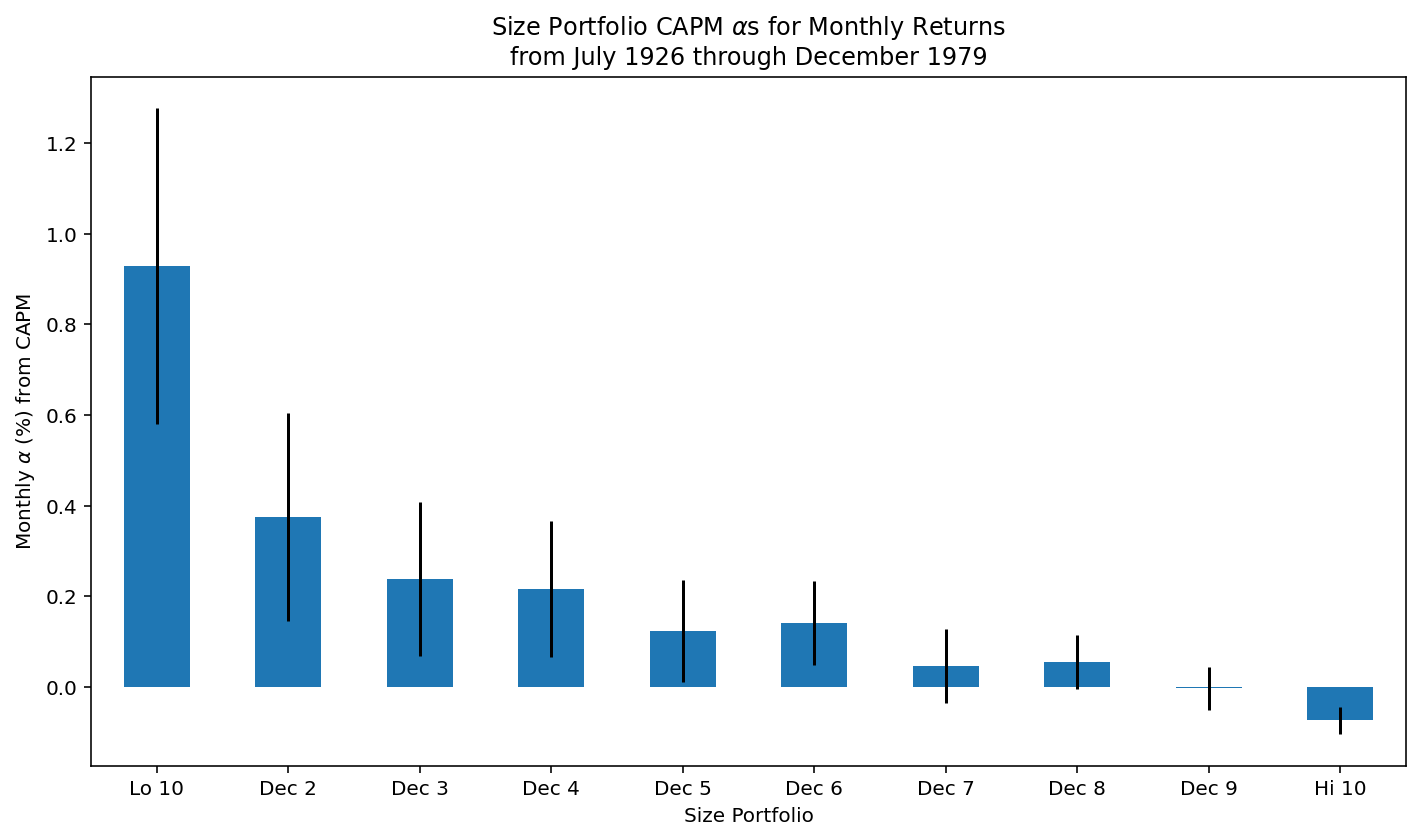

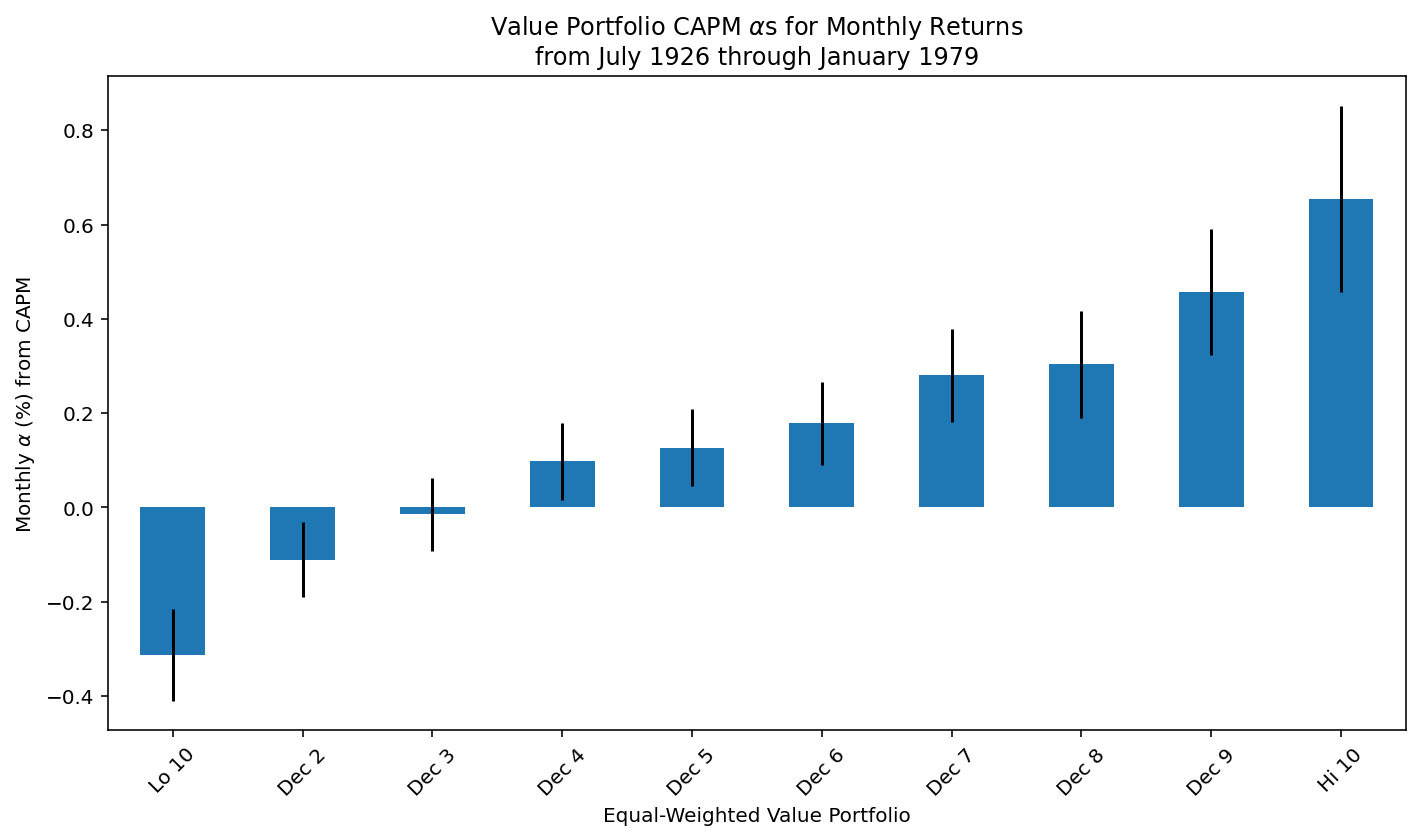

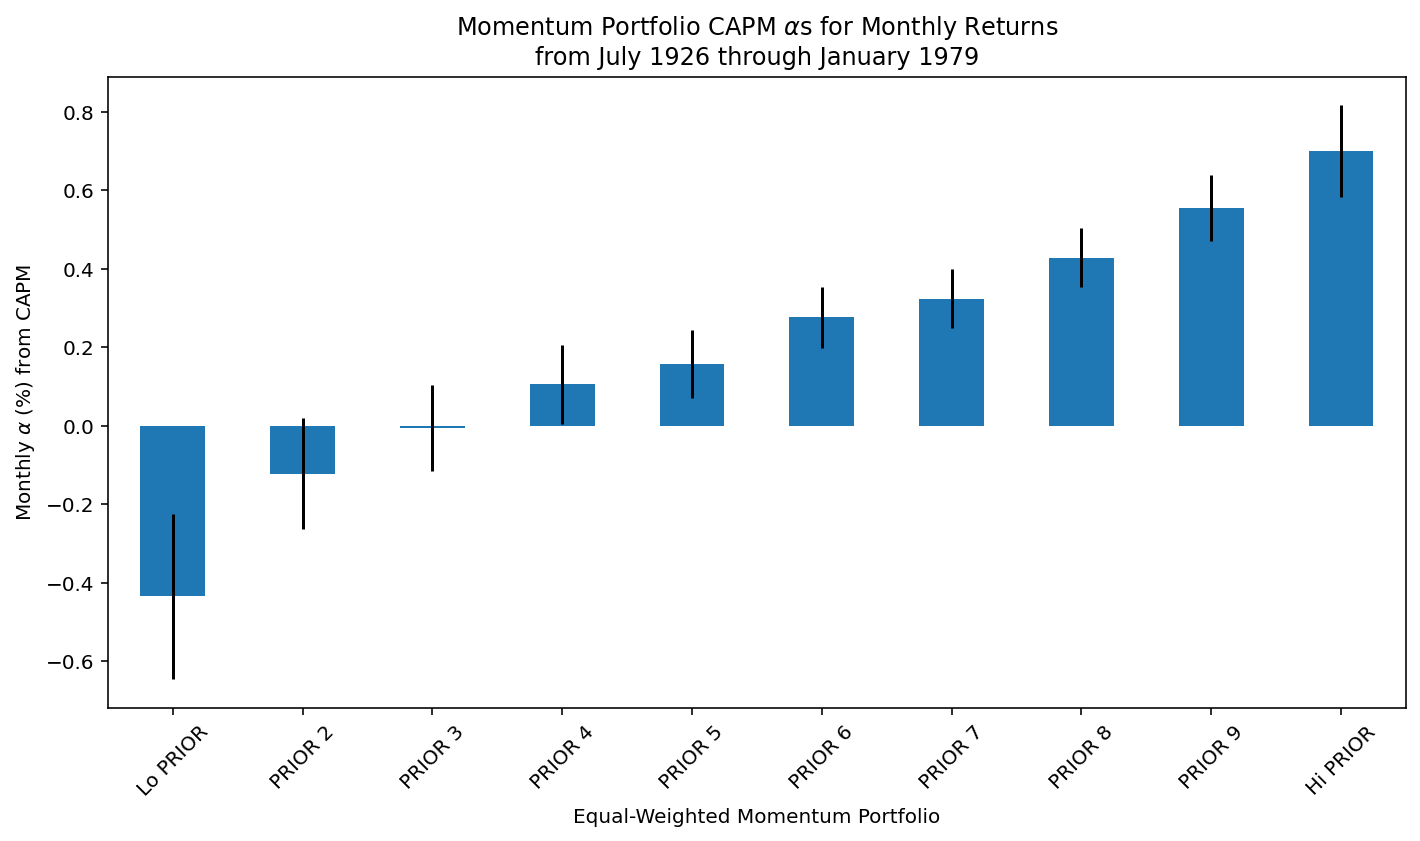

In [3]:
# Run the complete analysis
results = perform_market_analysis()

# Check if results were generated successfully
if results is not None:
    # Access specific results
    etf_stats = results['etf_stats']
    djia_stats = results['djia_stats']
    beta_portfolios = results['beta_portfolios']
    leveraged_betas = results['leveraged_betas']
    rolling_coefficients = results['rolling_coefficients']
    size_coefs = results['size_coefs']
    value_coefs = results['value_coefs']
    momentum_coefs = results['momentum_coefs']